In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# Best Machine Learning Approach for Loan Default Prediction
## Preprocessing Steps

# Handle missing values (imputation or removal).
## Encode categorical variables (one-hot encoding or label encoding).
## Scale numerical variables to normalize differences in magnitude.
# Recommended Models

## Gradient Boosting (XGBoost, LightGBM): Works well for structured financial data.
## Random Forest: Robust and interpretable with feature importance.
## Logistic Regression: A good baseline model for probability estimation.
## Neural Networks (if dataset is large and nonlinear patterns exist).
# Key Features to Focus On

## **Due Amount, Outstanding Amount, CRB Score, Number of Bounced Cheques, Monthly Income, Loan Term, Number of Debit Transactions.**

In [2]:
file_path = "final_merged_df_5p.csv"
chunk_size = 100000

data_chunks = []
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    data_chunks.append(chunk)

merged_df = pd.concat(data_chunks, ignore_index=True)

/tmp/ipykernel_10426/3013795782.py:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):


# Handle Missing Values

In [3]:
merged_df = merged_df.dropna(thresh=len(merged_df) * 0.3, axis=1)  # Drop columns with >30% missing values

num_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns
merged_df[num_cols] = merged_df[num_cols].fillna(merged_df[num_cols].median())  # Fill numerical missing values with median

cat_cols = merged_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    merged_df[col] = merged_df[col].fillna(merged_df[col].mode()[0])  # Fill categorical missing values with mode

In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584110 entries, 0 to 584109
Data columns (total 53 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Application_ID                           584110 non-null  object 
 1   Key                                      584110 non-null  int64  
 2   Loan_Type                                584110 non-null  object 
 3   Contract_Start_Date                      584110 non-null  object 
 4   Expected_Contract_End_Date               584110 non-null  object 
 5   Actual_Contract_End_Date                 584110 non-null  object 
 6   Loan_Term                                584110 non-null  int64  
 7   Total_Loan_Amount                        584110 non-null  float64
 8   Snapshot Date                            584110 non-null  object 
 9   Outstanding Amount                       584110 non-null  float64
 10  Due Amount                      

# Define Target Variable

In [5]:
merged_df['Default'] = merged_df['Number of Days Past Due'].apply(lambda x: 1 if x > 30 else 0)
merged_df.drop(columns=['Number of Days Past Due'], inplace=True)  # Prevent data leakage

# Feature Selection

In [6]:
selected_features = [
    'Total_Loan_Amount', 'CRB Score', 'Monthly_Income', 
    'Number of Bounced Cheques', 'Number of Debit Card POS Transactions'
]

# Categorical Features
selected_features += ['Loan_Type', 'Employment_Status', 'CRB Grade', 'Marital_Status', 'Gender']

# Removing leakage features (`Due Amount`, `Outstanding Amount`)
merged_df = merged_df[selected_features + ['Default']]

# Encoding Categorical Variables

In [8]:
label_encoders = {}
for col in merged_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le

# Splitting Data (Stratified to Maintain Class Balance)

In [10]:
X = merged_df.drop(columns=['Default'])
y = merged_df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle Class Imbalance (SMOTE)

In [11]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Balanced class distribution:", np.bincount(y_train_resampled))

Balanced class distribution: [434236 434236]


# Feature Scaling

In [12]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Train the XGBoost Model

In [13]:
# Compute class weights to help with imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
scale_pos_weight = class_weights[1] / class_weights[0]

# Define XGBoost Model with Optimized Hyperparameters
xgb_model = XGBClassifier(
    n_estimators=50,          # Reduce trees to prevent overfitting
    max_depth=4,              # Shallower trees generalize better
    learning_rate=0.05,       # Lower learning rate for stability
    reg_lambda=1,             # L2 regularization
    reg_alpha=1,              # L1 regularization
    scale_pos_weight=scale_pos_weight,  # Adjust for class imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_resampled, y_train_resampled)

/home/techvia/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:18:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

# Model Evaluation

In [14]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\nModel Evaluation Metrics:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


Model Evaluation Metrics:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    108559
           1       0.39      0.95      0.55      8263

    accuracy                           0.89    116822
   macro avg       0.69      0.92      0.75    116822
weighted avg       0.95      0.89      0.91    116822

ROC-AUC Score: 0.9694272633140248


# Precision-Recall Curve

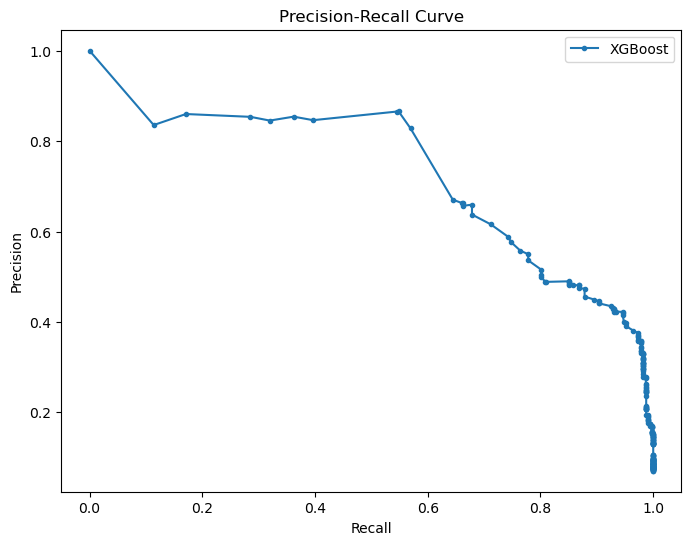

In [54]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Feature Importance

<Figure size 1200x600 with 0 Axes>

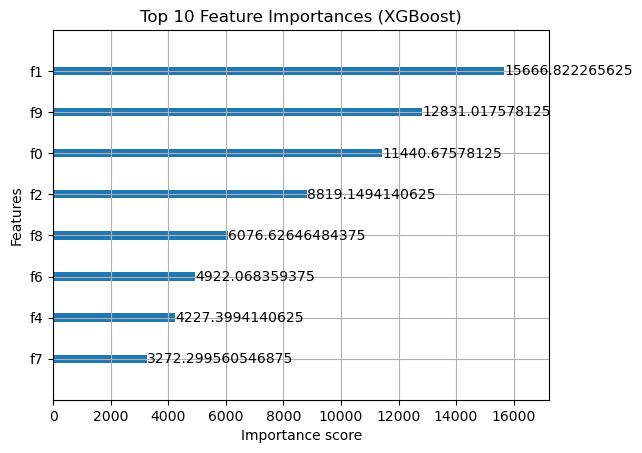

In [16]:
plt.figure(figsize=(12, 6))
plot_importance(xgb_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()